### Install bgfc_kit package from github 

In [30]:
!pip install git+https://github.com/peetal/bgfc_kit.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/peetal/bgfc_kit.git to /tmp/pip-req-build-3fa7k3g8
  Running command git clone -q https://github.com/peetal/bgfc_kit.git /tmp/pip-req-build-3fa7k3g8
  Resolved https://github.com/peetal/bgfc_kit.git to commit e3df737c204ef0c9f97a28fa028a69b1322dcc23
  Preparing metadata (setup.py) ... done
  Created wheel for bgfc-kit: filename=bgfc_kit-1.0.0-py3-none-any.whl size=15210 sha256=d15799d317a25f8ec2e64b93562f52464cc900a4711a5d0e30a2043f08455e3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1l2qryw/wheels/c2/43/f7/5eb8e554d07e831c44f50baa607c3cd385b76616ad17275a69
Successfully built bgfc-kit


In [6]:
import bgfc_kit
bgfc_kit

<module 'bgfc_kit' from '/home/peetal/.local/lib/python3.9/site-packages/bgfc_kit/__init__.py'>

## 1. Finite impulse model (FIR) design matrix 

In [13]:
from bgfc_kit.fir_design_matrix import generate_FIRdesignMat_template_toml
generate_FIRdesignMat_template_toml

<function bgfc_kit.fir_design_matrix.generate_FIRdesignMat_template_toml(output_dir: str)>

#### 1.1 Creating configuration file template
- Generating the FIR model design matrix needs many specific inforamtion about the task design. These information can be too chunky to include in a single function. 
- So you can first create an empty configuration file with all necessary parameters to generate the design matrix. After you fill it out, it can be reused to generate FIR model design matrices easily.

In [14]:
# generate an the template configuratio file
output_dir = '/projects/hulacon/peetal/bgfc_kit_test/'
generate_FIRdesignMat_template_toml(output_dir)

Let's have a quick look at the configuration file template
- The `PARAMETERS` are empty and will take your inputs that are specific to your experiment design. 
- The `COMMENTS` explains what each parameter is.
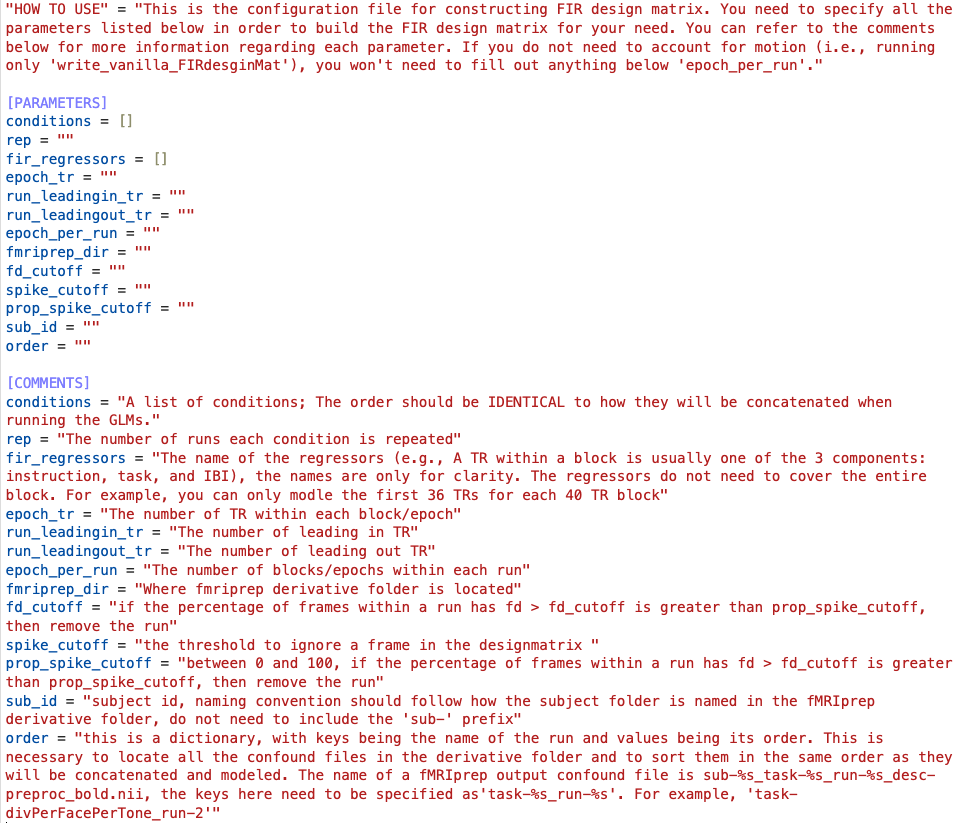

#### 1.2 Generating FIR model design matrix for a subject 
- The `write_personalized_FIRdesignMat` takes account of excessive motion and remove bad frame or runs (such as the last run in the current case. 
- Simpler version `write_vanilla_FIRdesignMat` can be used if no need to consider motions.

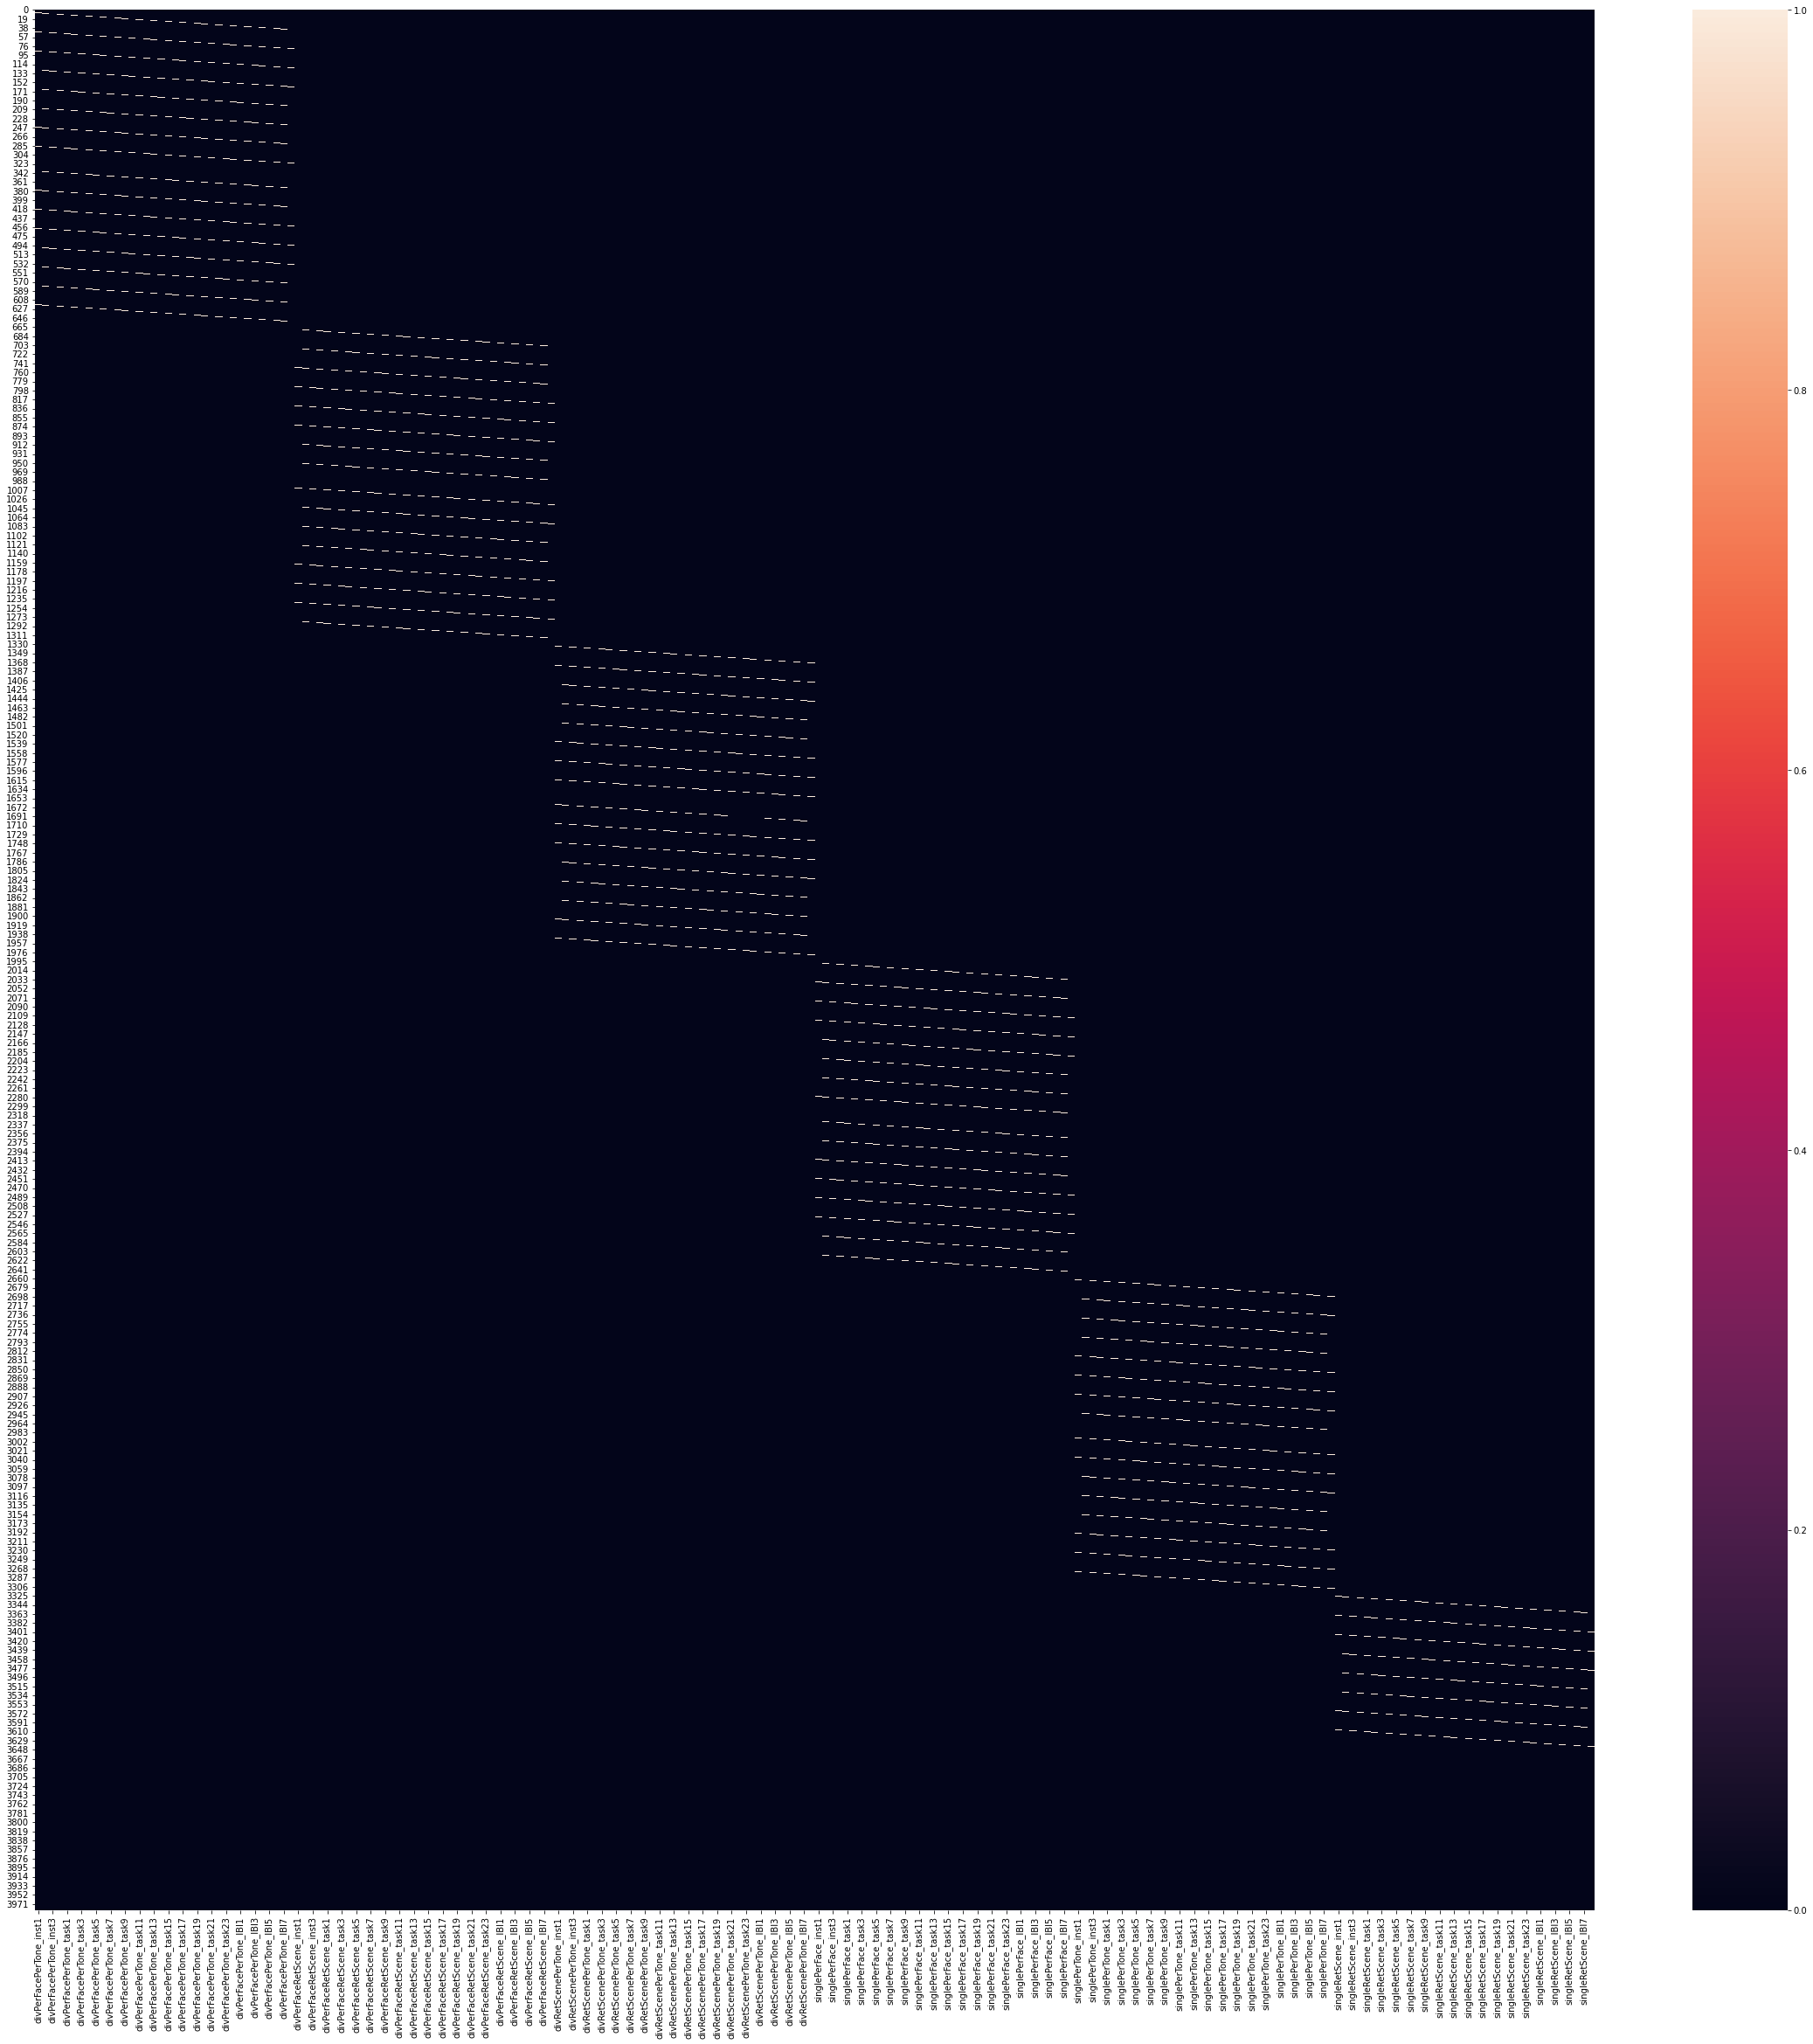

In [40]:
from bgfc_kit.fir_design_matrix import write_personalized_FIRdesginMat
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
write_personalized_FIRdesginMat(cfg_dir, output_dir)

## 2. BGFC preprocessing pipeline

- STEPS:
1. Spatial smoothing: niflow.fmri.fsl.create_susan_smooth
2. High-pass filtering: fsl.MeanImage; fsl.ImageMaths
3. Intensity normalization: fsl.ImageStats; fsl.ImageMaths
4. Skull strip: fsl.Applymask 
5. Nuisance GLM: FEAT implemented using nipype
6. Concatenation and Demean to obtain full timeseries: User defined function
7. FIR GLM: fsl.GLM 
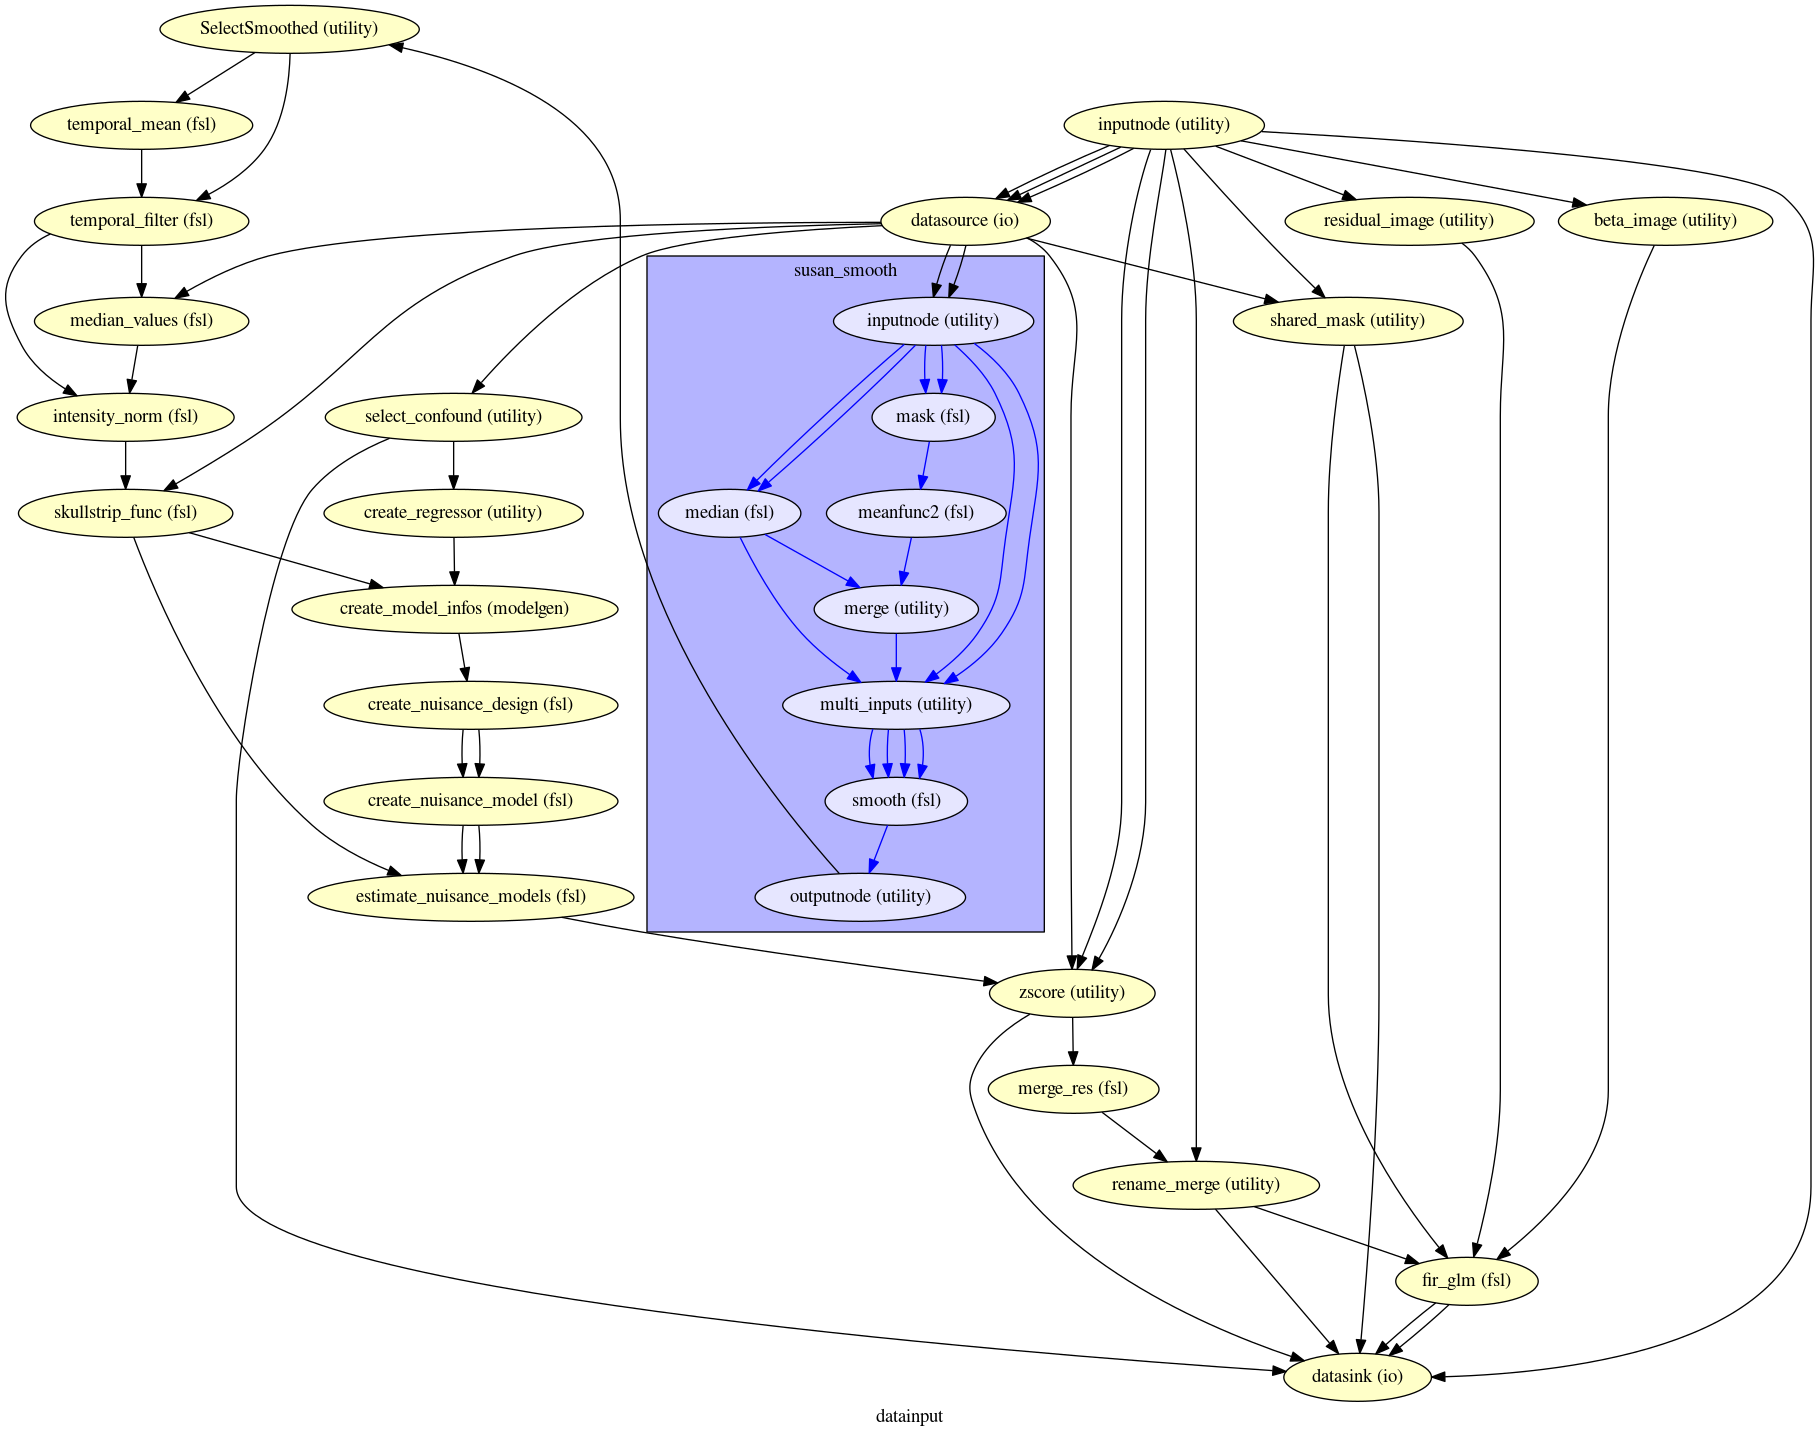

- OUTPUTs: 
1. Concatenated timeseries after nuisance but before FIR GLM. 
2. Beta values from FIR GLM. 
3. Concatenated (residual) timeseries after FIR GLM. 

#### 2.1 Creating configuration file template

In [43]:
from bgfc_kit.preprocessing_pipeline import generate_postfMRIprep_pipeline_template_toml
generate_postfMRIprep_pipeline_template_toml(output_dir)

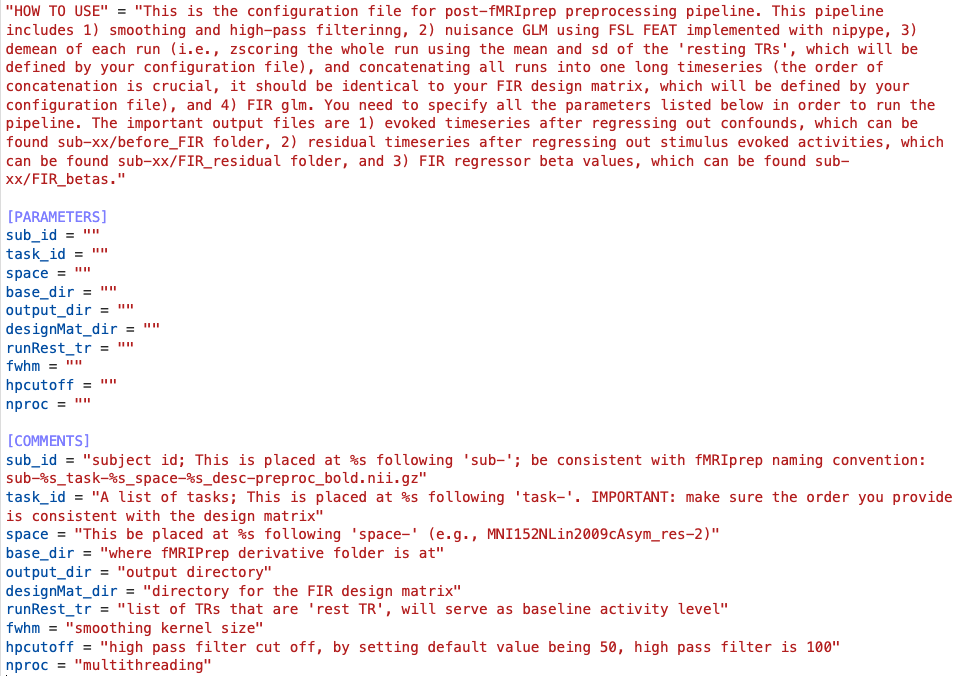

#### 2.2 Submit SLURM job to talapas

- This feature is specifically useful for talapas users. the `submit_postfMRIprep_pipeline_SLURM` function will write out a shell script and submit a slurm job automatically through subprocess. 

In [2]:
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
shell_dir = '/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh'
submit_postfMRIprep_pipeline_SLURM(cfg_dir, shell_dir, "hulacon", "fat", "post_fmriprep", "100GB")

Bash script submitted successfully.
Job ID: Submitted batch job 29548876


In [44]:
with open('/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh', 'r') as file:
    script_content = file.read()

# Print the content of the shell script
print(script_content)

#!/bin/bash
#SBATCH --account=hulacon
#SBATCH --partition=fat  
#SBATCH --job-name=post_fmriprep  
#SBATCH --mem=100GB
#SBATCH --time=1-00:00:00
#SBATCH --output=%x_%A_%a.log

module load fsl
module load ants
module load miniconda
module load singularity
conda activate jupyterlab-tf-pyt-20211020

python3 /gpfs/projects/hulacon/peetal/bgfc_kit/bgfc_kit/scripts/post_fMRIPrep_pipeline.py --sub-id 001 --task-id divPerFacePerTone_run-1 divPerFacePerTone_run-2 divPerFaceRetScene_run-1 divPerFaceRetScene_run-2 divRetScenePerTone_run-1 divRetScenePerTone_run-2 singlePerFace_run-1 singlePerFace_run-2 singlePerTone_run-1 singlePerTone_run-2 singleRetScene_run-1 singleRetScene_run-2  --space T1w --base-dir /projects/hulacon/peetal/divatten --output-dir /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data --designMat-dir /projects/hulacon/peetal/bgfc_kit_test/fir_design_matrix.txt --run-restTR 38 39 40 41 42 43 44 45 46 47 48 49 78 79 80 81 82 83 84 85 86 87 88 89 118 119 120 121 122 123 124 1

In [45]:
!tree /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001

/projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001
|-- FIR_betas
|   `-- sub-001_beta216.nii.gz
|-- FIR_residual
|   `-- sub-001_res3984.nii.gz
|-- before_FIR
|   `-- sub-001_nuisanceRES_CONCAT.nii.gz
|-- nuisance_regressor
|   |-- sub-001_task-divPerFacePerTone_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divPerFacePerTone_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divPerFaceRetScene_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divPerFaceRetScene_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divRetScenePerTone_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-divRetScenePerTone_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-singlePerFace_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-singlePerFace_run-2_desc-confounds_timeseries_selected.csv
|   |-- sub-001_task-singlePerTone_run-1_desc-confounds_timeseries_selected.csv
|   |-- sub-00

In [1]:
class StructDict(dict):
    '''Class that adds a structure type syntax to dictionaries,
       i.e. 'dict.field' will invoke dict['field']
    '''

    def __getattr__(self, key):
        '''Implement getattr to support syntax "data.field"'''
        try:
            val = self[key]
        except KeyError:
            val = None
        return val

    def __setattr__(self, key, val):
        '''Implement setattr to support syntax "data.field=x"'''
        self[key] = val

    def __delattr__(self, key):
        '''Implement delattr to support syntax "del data.field"'''
        if key in self:
            del self[key]

    def __getstate__(self):
        '''Needed for pickling, return the underlying dictionary'''
        return dict(self)

    def __setstate__(self, dict_entries):
        '''Needed for pickling, set the underlying dictionary'''
        self.update(dict_entries)

    def copy(self):
        return StructDict(super().copy())


def copy_toplevel(data):
    cptl = StructDict()
    for key, val in data.items():
        if isinstance(val, dict):
            continue
        if type(val) == list:
            if isinstance(val[0], dict):
                continue
        cptl[key] = val
    return cptl


def recurseCreateStructDict(data):
    '''Given a recursive dictionary, i.e. a dictionary that has
            child dictionaries or lists of dictionaries,
            convert each child dictionary to a StructDict.
      '''
    if isinstance(data, dict):
        tmpDict = StructDict()
        for key, value in data.items():
            tmpDict[key] = recurseCreateStructDict(value)
        return tmpDict
    elif isinstance(data, list):
        tmpList = []
        for value in data:
            tmpList.append(recurseCreateStructDict(value))
        return tmpList
    return data

In [ ]:
def applyAntsTransform()

call(f"singularity exec -B {base_dir}:/base /projects/hulacon/peetal/divatten/preprocess/fmriprep-21.0.2.simg antsApplyTransforms --verbose 1 -i /base/{schaefer200_MNI152NLin2009cAsym_res2} -o /base/{schaefer_t1w} -r /base/{t1_ref} -t /base/{MNI_T1_h5} -n NearestNeighbor", shell = True)

In [97]:
# import numpy as np 
# import pandas as pd
# import toml,os,glob
# from nilearn.regions import img_to_signals_labels
# import numpy.ma as ma
# import matplotlib.pyplot as plt
# from scipy.stats import sem
# def unpack_conf(FIRdesignMat_conf_dir:str, postfMRIprep_conf_dir:str): 

#     """
#     This function takes in the configuration toml file and unpack it into structdict data structure 
#     The configuration files contain important information that can be reused in subsequent analyses. 
    
#     Parameters
#     ----------
#     FIRdesignMat_conf_dir: 
#         The directory for FIRdesignMat_conf.toml generated by the `fir_design_matrix` module. 
#         (see https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/fir_design_matrix.py)
#     postfMRIprep_conf_dir: 
#         The directory for postfMRIprep_pipeline_config.toml generated by the `preprocessing_pipeline` module. 
#         (https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/preprocessing_pipeline.py)
    
#     Returns
#     --------
#     fir_cfg: dictionary-like data structure, keys are parameters; values are experiment-specific information in the config file 
#     preprocess_cfg: dictionary-like data structure, keys are parameters; values are experiment-specific information in the config file 
#     """
    
#     # load FIRdesignMat configuration file
#     with open(FIRdesignMat_conf_dir, "r") as toml_file:
#         fir_cfg = toml.load(toml_file)
#     fir_cfg = recurseCreateStructDict(fir_cfg)
#     fir_cfg = fir_cfg.PARAMETERS
    
#     # load postfMRIprep configuration file
#     with open(postfMRIprep_conf_dir, "r") as toml_file:
#         preprocess_cfg = toml.load(toml_file)
#     preprocess_cfg = recurseCreateStructDict(preprocess_cfg)
#     preprocess_cfg = preprocess_cfg.PARAMETERS

#     return fir_cfg, preprocess_cfg 

# def load_sub_data(input_data, atlas, mask) -> np.ndarray:
    
#     """
#     This function uses the selected parcellation scheme to divide the input data into parcels 
    
#     Parameters
#     ----------
#     input_data: 
#         A string pointing to the 4D timeseries niimg-like object (most likely to be the residual activity data). 
#     atlas: 
#         A string pointing to the 3D predefine parcellation scheme. 
#     mask: 
#         A string pointing to the 3D subject functional mask. 

#     Returns
#     --------
#     signal: a 2d numpy array, first dimension is Parcel and the second is TR.
#     """
    
#     signal, _ = img_to_signals_labels(input_data, atlas, mask)
    
#     # make sure to transpose the signal, so that the first dimension is parcel (instead of TR). 
#     return signal.T 

# def detect_bad_frame(sub_dir, signal, order, run_prop, spike): 
    
#     """
#     Residual timeseries can be contaminated by head motion, this function systematically scans the residual timeseries, 
#     identifying and masking the time points near a head motion spike based on framewise displacements measured by fMRIprep. 
#     Subsequently, motion-corrected BGFC matrices can be computed using numpy.ma.corrcoef followed by Fisher z-transformation, 
#     and this operation is available for both epoch- and condition-level analyses.
    
#     Parameters 
#     ----------
#     sub_dir: 
#         This is used to locate the directory that contains the fmriprep output confounds for this subject,
#         Which should be `base_dir/derivative/sub_dir/func`
#     signal: 
#         The output of load_sub_data, the shape is (nparcel, ts) 
#     order: 
#         This information is contained in the configuration file 
#         This is a dictionary, with keys being the name of the run and values being its order. 
#         This is necessary to locate all the confound files in the derivative folder and to sort them in the same order as they will be concatenated and modeled.
#         The name of a fMRIprep output confound file is sub-%s_task-%s_run-%s_desc-preproc_bold.nii, the keys here need to be specified as'task-%s_run-%s'. 
#         For example, 'task-divPerFacePerTone_run-2'. 
#     run_prop: 
#         This information is contained in the configuration file 
#         The proportion of frames with FD > 0.5 within each run, exceeding which removes the run (5%).
#     spike: 
#         This information is contained in the configuration file 
#         The spike cutoff, meaning that if a frame has FD greater than cutoff (2mm), then it would be treated as a spike. 
        
#     Return 
#     -------
#     ts: signal without bad frames, the shape is still (nparcel, ts), but bad frames are np.nan across all TR
#     """

#     # get confound files for the participant, order it as how 12 runs are being concatenated. 
#     confound_files = glob.glob(os.path.join(sub_dir, "*_run-*_desc-confounds_timeseries.tsv"))
#     confound_files.sort(key=lambda x: order['_'.join(x.split("_")[1:3])])
    
#     # len(ts)=3984, if 0, then remove the corresponding column in the FIR matrix. 
#     ts = []
#     for f in confound_files: 
#         df = pd.read_csv(f,sep = '\t')
#         motion = list(df['framewise_displacement']) # get FD 
#         outlier_prop = round(np.sum(np.array(motion)>0.5)/len(motion)*100,2) # %of frames that have FD>0.5
        
#         if outlier_prop > run_prop: # remove the whole run (all frames are bad frames) 
#             ts_run = [0 for _ in range(len(motion))]
#         else:   
#         # otherwise check spike, but at the beginning, all timepoints are good frames. 
#             ts_run = [1 for _ in range(len(motion))]
#             for idx, m in enumerate(motion): 
#                 if np.isnan(m) or m <= spike: pass # if the frist frame or not a spike 
#                 if m > spike: # if spike 
#                     ts_run[idx-1], ts_run[idx] = 0, 0 # remove the previous and the current frame 
#                     if idx + 1 < len(motion): # if not the last frame, remove the next frame 
#                         ts_run[idx+1] = 0 
#         ts += ts_run 
    
#     # check length 
#     if len(ts) != signal.shape[1]: 
#         print("Timeseries length does not match")
#         return 
    
#     for idx, frame in enumerate(ts): # remove bad frames from timeseries 
#         if frame == 1: 
#             pass
#         else: 
#             signal[:, idx] = np.nan
    
#     return signal

# def parcellate_rmMotion_batch(FIRdesignMat_conf_dir:str, postfMRIprep_conf_dir:str, sub, atlas):

#     """
#     This function performs parcellation and remove motion frames for a list of subjects.
#     Residual timeseries computed by postfMRIprep_pipeline was first parcellated using input atlas. 
#     Then the output signals further cleaned to remove the influnces of head motion. 
    
#     Parameters 
#     ----------
#     FIRdesignMat_conf_dir: 
#         The directory for FIRdesignMat_conf.toml generated by the `fir_design_matrix` module. 
#         (see https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/fir_design_matrix.py)
#     postfMRIprep_conf_dir: 
#         The directory for postfMRIprep_pipeline_config.toml generated by the `preprocessing_pipeline` module. 
#         (https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/preprocessing_pipeline.py)
#     sub: 
#         A list of subject, no prefix (e.g., 1,2,14)
#     atlas: 
#         A string pointing to the 3D predefine parcellation scheme. 

#     Return 
#     -------
#     ts: signal without bad frames, the shape is still (nparcel, ts), but bad frames are np.nan across all TR
#     """
#     # unpack configuration file for useful information 
#     fir_cfg, preprocess_cfg = unpack_conf(FIRdesignMat_conf_dir, postfMRIprep_conf_dir)
#     order, run_prop, spike = eval(fir_cfg.order), fir_cfg.spike_cutoff, fir_cfg.prop_spike_cutoff
#     res_base_dir, derivative_base_dir = preprocess_cfg.output_dir, preprocess_cfg.base_dir

#     # batch process
#     activity_data = []
#     for sid in sub: 
#         # parcellation 
#         data_dir = os.path.join(res_base_dir, f"sub-{sid:03d}", "FIR_residual", f"sub-{sid:03d}_res.nii.gz")
#         mask = os.path.join(res_base_dir, f"sub-{sid:03d}", "task_shared_mask", f"sub-{sid:03d}_task-shared_brain-mask.nii.gz")
#         sub_signal = load_sub_data(data_dir, atlas, mask) # a list of 2d array (nparcel, ts) 
#         # clean motion 
#         sub_dir = os.path.join(derivative_base_dir, "derivative", f'sub-{sid:03d}/func')
#         sub_signal_nospike = detect_bad_frame(sub_dir, sub_signal, order, run_prop, spike)
#         # add to this list 
#         activity_data.append(sub_signal_nospike)
#     activity_dat_np = np.stack(activity_data, axis = 0)
#     return activity_dat_np

# def define_epoch(FIRdesignMat_conf_dir:str, postfMRIprep_conf_dir:str): 

#     """
#     This function define the TRs for each epoch of each condition. This is necessary for separting the residual timeseries 
#     into epochs of each condition. 
    
#     Parameters 
#     ----------
#     FIRdesignMat_conf_dir: 
#         The directory for FIRdesignMat_conf.toml generated by the `fir_design_matrix` module. 
#         (see https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/fir_design_matrix.py)
#     postfMRIprep_conf_dir: 
#         The directory for postfMRIprep_pipeline_config.toml generated by the `preprocessing_pipeline` module. 
#         (https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/preprocessing_pipeline.py)

#     Return 
#     -------
#     epoch: 
#         3d array with the shape of (# of condition, # of epoch, # of total TR). This array defines the specific TRs associated 
#         with each epoch of each condition. For example, if each epoch contains 40 TR, then sum(epoch[0,0,:])=40
#     """
    
#     # unpack configuration file for useful information 
#     fir_cfg, preprocess_cfg = unpack_conf(FIRdesignMat_conf_dir, postfMRIprep_conf_dir)
#     epoch_cond = np.repeat(fir_cfg.conditions,fir_cfg.epoch_per_run*fir_cfg.rep)

#     # create the epoch design matrix for a given run 
#     per_epoch = np.repeat(1,fir_cfg.epoch_tr)
#     epoch_shape_per_run = np.eye(fir_cfg.epoch_per_run, fir_cfg.epoch_per_run)
#     per_run_task = np.kron(epoch_shape_per_run,per_epoch)
#     dummy_in = np.zeros((fir_cfg.epoch_per_run,fir_cfg.run_leadingin_tr))
#     dummy_out = np.zeros((fir_cfg.epoch_per_run,fir_cfg.run_leadingout_tr))
#     per_run_full = np.concatenate((dummy_in, per_run_task,dummy_out), axis = 1)
    
#     # epoch template, need to crop the blocks for each condition 
#     run_shape_per_sub = np.eye(len(fir_cfg.conditions)*fir_cfg.rep,len(fir_cfg.conditions)*fir_cfg.rep)
#     sub_epoch_template = np.kron(run_shape_per_sub,per_run_full)
#     sub_epoch_template_df = pd.DataFrame(sub_epoch_template.T, columns = epoch_cond)

#     # define TRs in each epoch 
#     cond_slice = []
#     for cond in fir_cfg.conditions: 
#         df_copy = sub_epoch_template_df.copy(deep = True)
#         col_index = np.nonzero((df_copy.columns == cond) == False)[0]
#         df_copy.iloc[:,col_index] = df_copy.iloc[:,col_index].replace(1,0)
#         df_copy = df_copy.T
#         cond_slice.append(np.array(df_copy))
#     sub_epoch = np.stack(cond_slice, axis = 0).astype(int)

#     return sub_epoch 

# def separate_epochs(activity_data, epoch_list):
#     """ 
#     This function is the first step of dividing the timeseries into list of epochs with condition labels, 
#     using the experiment specific epoch list. Specifically, this function divide the timeseries by condition, 
#     and extract all TRs within each condition. 
    
#     Parameters
#     ----------
#     activity_data: 
#         3D array in shape [nSub, nVoxels/nParcel, nTRs]
#         The masked activity data organized in voxel*TR formats of all subjects.
#     epoch_list: 
#         List of 3D array in shape [condition, nEpochs, nTRs]
#         Specification of epochs and conditions, assuming all subjects have the same number of epoch. len(epoch_list) equals the number of subjects.

#     Returns
#     -------
#     raw_data: 
#         List of 2D array in shape [nParcels, timepoints]
#         The data organized in epochs. len(raw_data) equals (# of subjects) * (# of conditions per subject)
#     labels:
#         List of 1D array, which is the condition labels of the epochs
#         len(labels) labels equals len(raw_data). Showing the 
#     """
#     raw_data = []
#     labels = []
#     nsub = activity_data.shape[0]
#     activity_data = [activity_data[i,:, :] for i in range(nsub)] # turn stacked np array into a list 
    
#     for sid in range(len(epoch_list)): #for a given subject
#         epoch = epoch_list[sid] # get their npy array
#         for cond in range(epoch.shape[0]): # for a given condition
#             # for each condition
#             sub_epoch = epoch[cond, :, :]
#             ts = np.zeros(epoch.shape[2])
#             for eid in range(epoch.shape[1]):
#                 r = np.sum(sub_epoch[eid, :])
#                 if r > 0:   # there is an epoch in this condition
#                     # collapse all epoch of a condition to a single time series
#                     ts[sub_epoch[eid, :] == 1] = 1
#             ts = ts.astype(bool)
#             mat_cond = activity_data[sid][:,ts]
#             mat_cond = np.ascontiguousarray(mat_cond)
#             raw_data.append(mat_cond)
#             labels.append(cond)

#     return raw_data, labels

# def _divide_into_epoch(ts, epoch_length): 
    
#     """
#     This function divide full timeseries into same length epochs
    
#     Parameters
#     ----------
#     ts: 
#         a 2d array, first dimension is number of parcels and th second dimension is TR/epoch * epoch num 
#         epoch_length: TR/epoch 
    
#     yiled:
#     ------
#         a generater for TRs within each epoch. 
    
#     """
#     ts_len = ts.shape[1]
#     for i in range(0, ts_len, epoch_length):  
#         yield ts[:,i:i + epoch_length] 
        
# def separate_epochs_per_condition(raw_data, labels, condition_label, epoch_list): 
    
#     """
#     This function is the second step of dividing the full (residual) timeseries into epochs. Sepcifically, it filtered 
#     out all TRs of the same condition, then divided the TRs into epoch structure, based on the epoch_list. 
    
#     Parameter
#     ----------
#     raw_data: 
#         Output from function `separate_epochs`
#     labels: 
#         Second otput from function `separate_epochs`
#     condition_label: 
#         One of the condition in the `label` output from `separate_epochs`. If there were 6 conditions, 
#         condition_labels are 0,1,2,3,4,5.
#     epoch_list: 
#         List of 3D array in shape [condition, nEpochs, nTRs]
#         Specification of epochs and conditions, assuming all subjects have the same number of epoch. len(epoch_list) equals the number of subjects.
    
#     Return
#     ------
#     cond_epoch_ts: 
#         a list of 3d array. 
#         The length of the list is the number of subject. Each array is of the shape (# of epochs of the condition, # of parcels, # of TR per epoch)
    
#     """
#     nsub = len(epoch_list) # the number of subjects 
#     epoch_length = sum(epoch_list[0][0,0,:]) # count the number of TRs within each epoch 
#     cond_raw_data = [raw_data[cond] for cond in np.where(np.array(labels) == condition_label)[0].tolist()] # extract all TRs within the same condition 
#     cond_epoch_ts = []
#     # then divide into epoch structure. 
#     for sub in range(nsub):
#         cond_epoch_ts.append(np.stack(list(_divide_into_epoch(cond_raw_data[sub], epoch_length)), axis = 0))
#     return cond_epoch_ts

# def compute_sub_cond_connectome_ztrans_nobadframe(epoch_data:np.ndarray):
    
#     """
#     This function computes the z-transformed connectome for each subject for each condition. 
#     So each subject will have just 1 connectome each condition (averaged across epochs). 
#     This epoch-level processing is useful building graphs and for measuring individual differences. 
#     This function also cleans up unqualified epochs or unqualified frames: 
#     1) If all frames within this epoch is np.nan, drop the epoch
#     2) If some frames within this epoch is np.nan, drop the frame then compute the correlation matrix 
    
#     Parameters: 
#     -----------
#     epoch_data: 
#         A list of 2d array. 
#         The length equals the number of participant. Each array is of the shape (# of epoch, # of parcels, # of TR per epoch)

#     Yields: 
#     --------
#     sub_cond_connectome_ztrans:
#         A generator of 2d arrays. nParcel by nParcel Z-transformed correlation for each subject (averaged across all epochs). generator length is nsub
#     """
    
#     # basic information
#     sub_num = len(epoch_data) # the number of partcipants
#     epoch_num = epoch_data[0].shape[0] # the number of epochs 
    
#     for sub in range(sub_num): 

#         # grab the subject's data, shape is [nEpoch,nParcel,nTR]
#         sub_epoch = epoch_data[sub]
#         sub_epoch_connectome = []
#         for cur_epoch in range(epoch_num): 
#             if np.isnan(sub_epoch[cur_epoch,:,:]).all(): # if this epoch is full of na, meaning this epoch (run) has been dropped.
#                 pass 
#             else: 
#                 # compute connectome for each nonempty epoch 
#                 sub_epoch_connectome.append(ma.corrcoef(ma.masked_invalid(sub_epoch[cur_epoch,:,:])).filled())

#         # averave CorMat across all epochs 
#         sub_cond_connectome = np.mean(sub_epoch_connectome, axis = 0)
#         np.fill_diagonal(sub_cond_connectome, 0) # fill the diagnal with 0 for graph construction later

#         # Z transformation 
#         sub_cond_connectome_ztrans = np.arctanh(sub_cond_connectome)

#         yield sub_cond_connectome_ztrans
            
# def compute_epoch_cond_connectome_ztrans_nobadframe(epoch_data:np.ndarray):
    
#     """
#     This function computes the z-transformed connectome for each epoch for each condition. 
#     So each subject will have multiple connectomes for each condition. This epoch-level processing 
#     is useful for training machine learning models. This function also cleans up unqualified epochs
#     or unqualified frames: 
#     1) If all frames within this epoch is np.nan, drop the epoch
#     2) If some frames within this epoch is np.nan, drop the frame then compute the correlation matrix 
    
#     Parameters: 
#     -----------
#     epoch_data: 
#         A list of 2d array. 
#         The length equals the number of participant. Each array is of the shape (# of epoch, # of parcels, # of TR per epoch)
                
#     Yields: 
#     --------
#     all_connectomes: 
#         A nested list. Each sub list is epoch level (nParcel by nParcel) correlation matrix for a participant. 
#     """
    
#     # basic information
#     sub_num = len(epoch_data) # the number of partcipants
#     epoch_num = epoch_data[0].shape[0] # the number of epochs 

#     all_connectomes = []
#     for sub in range(sub_num): 
#         sub_connectomes = []
#         # grab the subject's data, shape is [16,200,36]
#         sub_epoch = epoch_data[sub]
#         for cur_epoch in range(epoch_num): 
#             if np.isnan(sub_epoch[cur_epoch,:,:]).all(): # if this epoch is full of na, meaning this epoch (run) has been dropped.
#                 pass 
#             else: 
#                 # compute connectome for each nonempty epoch 
#                 epoch_cond_connectome = ma.corrcoef(ma.masked_invalid(sub_epoch[cur_epoch,:,:])).filled()
#                 np.fill_diagonal(epoch_cond_connectome, 0) # fill the diagnal with 0 for graph construction later
#                 epoch_cond_connectome_ztrans = np.arctanh(epoch_cond_connectome) # Z transformation 
#                 sub_connectomes.append(epoch_cond_connectome_ztrans)
#         all_connectomes.append(sub_connectomes)
#     return all_connectomes 

# def vectorize_connectome(connectome_list):
    
#     """
#     This function extracts the upper triangle of any connectome, which will potentially serve as features 
#     for training machine learning models. 
    
#     Parameters: 
#     -----------
#     connectome_list: 
#         A nested list of connectomes (2d array of the shape nParcel x nParcel)
                
#     Returns: 
#     --------
#     connectome_vectors:
#         A list (len = subject) of list (len = epoch) of vectorized connectom(upper triangle, including diagnol)
#     """
#     sub_epoch_vector = []
#     for sub_conn_list in connectome_list: 
        
#         nparcel = sub_conn_list[0].shape[0]
#         vectorized_conn = [list(c[np.triu_indices(nparcel, k = 1)]) for c in sub_conn_list] 

#         sub_epoch_vector.append(vectorized_conn)
    
#     return sub_epoch_vector 

# def plot_parcel_FIR_estimates(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, parcel_id, sub_list, atlas): 

#     """
#     This function plots the estimates of FIR regressors across all subjects. These plots should serve 
#     as sanity checks for FIR model efficiency. The plot should reveal boxcart shape reflecting condition structure.
    
#     Parameters 
#     ----------
#     FIRdesignMat_conf_dir: 
#         The directory for FIRdesignMat_conf.toml generated by the `fir_design_matrix` module. 
#         (see https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/fir_design_matrix.py)
#     postfMRIprep_conf_dir: 
#         The directory for postfMRIprep_pipeline_config.toml generated by the `preprocessing_pipeline` module. 
#         (https://github.com/peetal/bgfc_kit/blob/main/bgfc_kit/preprocessing_pipeline.py)
#     sub_list: 
#         A list of subject, no prefix (e.g., 1,2,14)
#     atlas: 
#         A string pointing to the 3D predefine parcellation scheme. 

#     Return 
#     ----------
#     plot: 
#         FIR estimates for a specific parcel. 
#     """

#     # unpack configuration files for important information
#     fir_cfg, preprocess_cfg = unpack_conf(FIRdesignMat_conf_dir, postfMRIprep_conf_dir)
#     base_dir = preprocess_cfg.output_dir
    
#     signal_array = []
#     for sub in sub_list:
 
#         # file names for each participant 
#         beta_img = os.path.join(base_dir, f"sub-{sub:03d}", "FIR_betas", f"sub-{sub:03d}_beta.nii.gz")
#         mask = os.path.join(base_dir, f"sub-{sub:03d}", "task_shared_mask", f"sub-{sub:03d}_task-shared_brain-mask.nii.gz")
    
#         # apply parcellation
#         signals, labels = img_to_signals_labels(beta_img, atlas, mask)
#         signal_array.append(signals)
    
#     # sub, regressor, region 
#     signal_array = np.stack(signal_array, axis = 0)
    
#     #compute mean and se for the sample
#     signal_se = sem(signal_array, 0)
#     signal_mean = np.mean(signal_array, 0)
#     lower_bound = signal_mean - signal_se
#     upper_bound = signal_mean + signal_se
    
#     # plot 
#     fig, ax = plt.subplots(figsize=(20,3))
#     plt.plot(signal_mean[:,parcel_id])
#     plt.fill_between(range(0, 216), lower_bound[:,parcel_id], upper_bound[:,parcel_id], alpha=.3)
#     plt.show()
    

In [36]:
# FIRdesignMat_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
# postfMRIprep_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
# sub = [1]
# atlas = os.path.join('/projects/hulacon/peetal/divatten/post_fMRIPrep_pip_motionCorr', f"sub-001", "transformed_atlas", f"sub-001_schaefer200_T1W.nii.gz")
# activity_data = parcellate_rmMotion_batch(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, sub, atlas)

In [63]:
single_epoch = define_epoch(FIRdesignMat_conf_dir, postfMRIprep_conf_dir)
sub_epoch = [single_epoch for i in range(1)]
raw_data, labels = separate_epochs(activity_data, sub_epoch)

In [65]:
cond1 = separate_epochs_per_condition(raw_data,labels,0,sub_epoch)
cond2 = separate_epochs_per_condition(raw_data,labels,1,sub_epoch)
cond3 = separate_epochs_per_condition(raw_data,labels,2,sub_epoch)
cond4 = separate_epochs_per_condition(raw_data,labels,3,sub_epoch)
cond5 = separate_epochs_per_condition(raw_data,labels,4,sub_epoch)
cond6 = separate_epochs_per_condition(raw_data,labels,5,sub_epoch)

In [81]:
# compute connectome for each epoch for all subjects, geting a list of epochs 
cond1_epochlevel_corMat = list(compute_epoch_cond_connectome_ztrans_nobadframe(cond1))
cond1_sublevel_corMat = list(compute_sub_cond_connectome_ztrans_nobadframe(cond1))

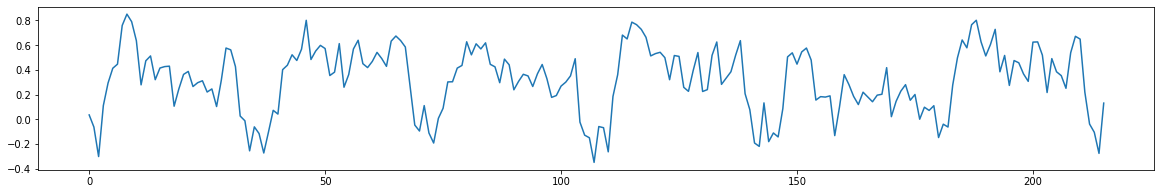

In [99]:
plot_parcel_FIR_estimates(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, 1, [1], atlas)